In [1]:
#importing all the necessary modules
import os
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2.17.0


In [3]:
#defining some constants
IMAGE_SIZE= 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30
data_dir = "leaf_images_aug"

In [4]:
#we are loading the dataset as a 4D Tensor, with shape [batch_size, height, width, channels].
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    batch_size= BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
)

Found 10122 files belonging to 6 classes.


In [5]:
type(dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [6]:
len(dataset) #number of batches

317

In [7]:
class_names = dataset.class_names #leaf diseases
# Get the number of images in each folder
image_counts = {class_name: len(os.listdir(os.path.join(f'{data_dir}', class_name))) for class_name in class_names}

print("Class names and their corresponding integer labels:")
for index, class_name in enumerate(class_names):
    print(f"{index}: {class_name}")


Class names and their corresponding integer labels:
0: bacterial_blight
1: cercospora_leaf_blight
2: downey_mildew
3: frogeye
4: healthy
5: soybean_rust


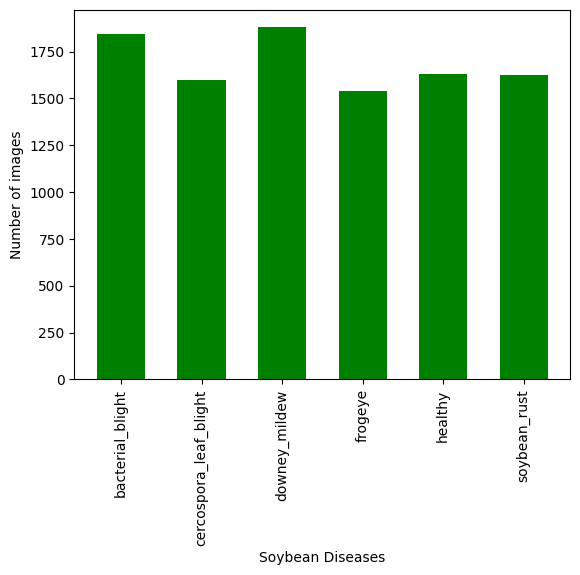

In [8]:
#plt.figure(figsize = (10,5))
plt.bar(list(image_counts.keys()), list(image_counts.values()), color = 'green', width = 0.6)
plt.xlabel("Soybean Diseases")
plt.ylabel("Number of images")
plt.xticks(rotation = 90)
plt.show()

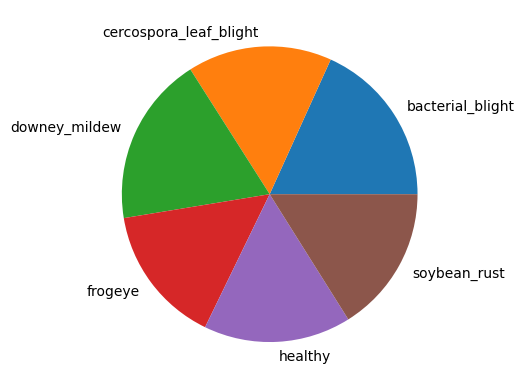

In [9]:
plt.pie(list(image_counts.values()), labels = list(image_counts.keys()))
plt.show()

In [10]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape) #shape of the batch of images, a 4D-Tensor
    print(label_batch.numpy()) #labels for our diseases, we convert the tensor into a numpy array
    print(type(label_batch))

(32, 224, 224, 3)
[3 2 1 4 3 3 5 1 1 1 4 2 1 5 3 0 5 5 5 1 0 1 0 0 5 0 4 5 5 2 0 0]
<class 'tensorflow.python.framework.ops.EagerTensor'>


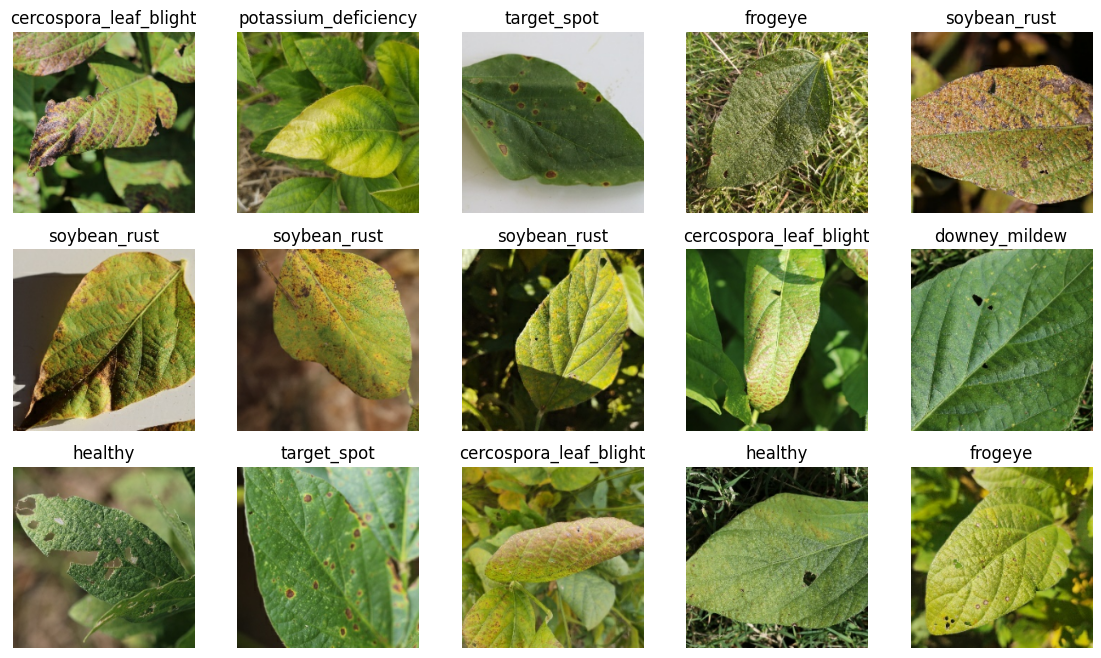

In [10]:
plt.figure(figsize = (14,8))
for batch_of_images, batch_of_labels in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i+1)
        plt.imshow(batch_of_images[i].numpy().astype('uint8')) #we convert the tensor into a numpy array of type 8 bit unsigned int
        plt.title(class_names[batch_of_labels[i]])
        plt.axis("off")

## Splitting the dataset

In [11]:
#we dont have train_test_split in tensors like we do in sci-kit learn, so we define our own function
def get_dataset_partitions_tf(ds, train_split = 0.7, valid_split = 0.15, test_split = 0.15, shuffle = True, shuffle_size = 10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size) #you can also give a seed
    ds_size = len(ds)
    train_size = int(len(ds) * train_split)
    valid_size = int(len(ds) * valid_split)
    test_size = int(len(ds) * test_split)

    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size + valid_size).take(test_size)

    return train_ds, valid_ds, test_ds

In [12]:
train_ds, valid_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(valid_ds), len(test_ds)

(211, 45, 45)

In [16]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [17]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 224, 224, 3)
[1 6 3 2 1 5 1 6 7 6 4 6 4 6 0 3 3 5 1 4 5 1 1 1 6 6 4 6 4 2 2 3]


In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

<h2>ResNet50</h2>

In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze all layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False
# Add custom layers on top of ResNet50
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Pooling the feature maps
x = layers.Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = layers.Dense(8, activation='softmax')(x)  # Final output layer with 8 classes

# Create the final model
model = models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [17]:
early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [18]:
history = model.fit(train_ds, epochs = EPOCHS, verbose = 1, validation_data = valid_ds, callbacks = [early_stopper])


Epoch 1/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.6678 - loss: 1.0023 - val_accuracy: 0.8819 - val_loss: 0.3365
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.8678 - loss: 0.3688 - val_accuracy: 0.9285 - val_loss: 0.2132
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.9134 - loss: 0.2468 - val_accuracy: 0.9438 - val_loss: 0.1604
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.9383 - loss: 0.1686 - val_accuracy: 0.9396 - val_loss: 0.1743
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.9497 - loss: 0.1449 - val_accuracy: 0.9715 - val_loss: 0.0844
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9634 - loss: 0.1120 - val_accuracy: 0.9761 - val_loss: 0.0692
Epoch 7/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9663 - loss: 0.1008 - val_accuracy: 0.9819 - val_loss: 0.0627
Epoch 8/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.9805 - loss: 0.0610 - val_accu

<h2>Custom CNN</h2>

In [19]:
#lets define our preprocessing pipeline
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [20]:
#lets define our data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.2),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
    #layers.RandomTranslation
])

In [25]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape = input_shape), #input_shape is deprecated
    #our data augmentation and resizing and rescaling layers
    data_augmentation,
    resize_and_rescale,

    #defining our concolutional layers
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),

    #defining our dense layers
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = (None, 224, 224, 3))

In [26]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,784 (671.03 KB)

 Trainable params: 171,784 (671.03 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
import visualkeras
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'

visualkeras.layered_view(model)
#, spacing=30, color_map = color_map, scale_xy= 0.9

ModuleNotFoundError: No module named 'visualkeras'

In [28]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)

In [29]:
history = model.fit(train_ds, epochs = EPOCHS,  batch_size = BATCH_SIZE, verbose = 1, validation_data = valid_ds)

Epoch 1/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 64s 285ms/step - accuracy: 0.1662 - loss: 2.0330 - val_accuracy: 0.1729 - val_loss: 2.0154
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.1713 - loss: 2.0099

In [20]:
model.save('test_2_26_sept.keras')

<h2>Model Metrics</h2>

In [16]:
model = tf.keras.models.load_model("test_2_26_sept.keras")

In [17]:
scores = model.evaluate(test_ds)
scores

45/45 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9962 - loss: 0.0135


[0.013876277953386307, 0.9965277910232544]

In [21]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation accuracy')

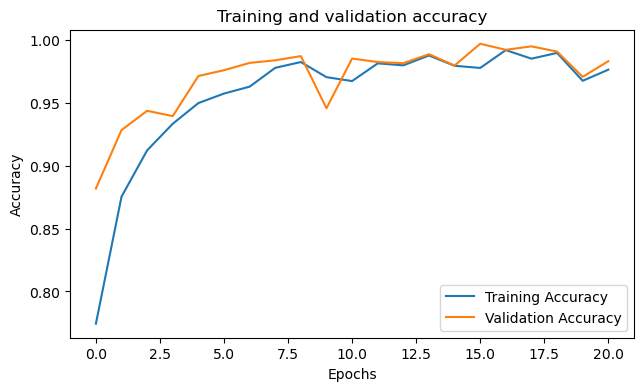

In [22]:
plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
plt.plot( accu, label = 'Training Accuracy')
plt.plot( val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")

plt.subplot(1,2,2)
plt.plot( loss, label = 'Training Accuracy')
plt.plot( val_loss, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation loss")
plt.show()

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# Evaluate your model on the test dataset
y_true = []
y_pred = []

# Assuming you have a test dataset
for x_batch, y_batch in test_ds:
    y_true.extend(y_batch.numpy())
    predictions = model.predict(x_batch)
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

# Convert lists to arrays for sklearn metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Clear the output
clear_output(wait=True)
# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro' for equal weight
recall = recall_score(y_true, y_pred, average='weighted')  # or 'macro'
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro'

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print("Classification Report : ")
clf_report = classification_report(y_true, y_pred)
print(clf_report)

Precision: 0.9938
Recall: 0.9938
F1-Score: 0.9937
Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        78
           1       1.00      1.00      1.00       233
           2       1.00      0.98      0.99        88
           3       0.99      1.00      0.99       241
           4       0.99      1.00      0.99       245
           5       1.00      1.00      1.00       157
           6       1.00      0.99      0.99       261
           7       1.00      1.00      1.00       137

    accuracy                           0.99      1440
   macro avg       0.99      0.99      0.99      1440
weighted avg       0.99      0.99      0.99      1440



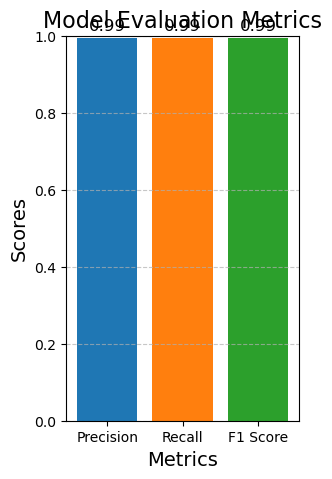

In [24]:
metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Create lists for the bar chart
labels = list(metrics.keys())
values = list(metrics.values())

# Create a bar chart
plt.figure(figsize=(3, 5))
plt.bar(labels, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])  # Custom colors for bars
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.title('Model Evaluation Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability

# Show the values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', fontsize=12)

plt.show()


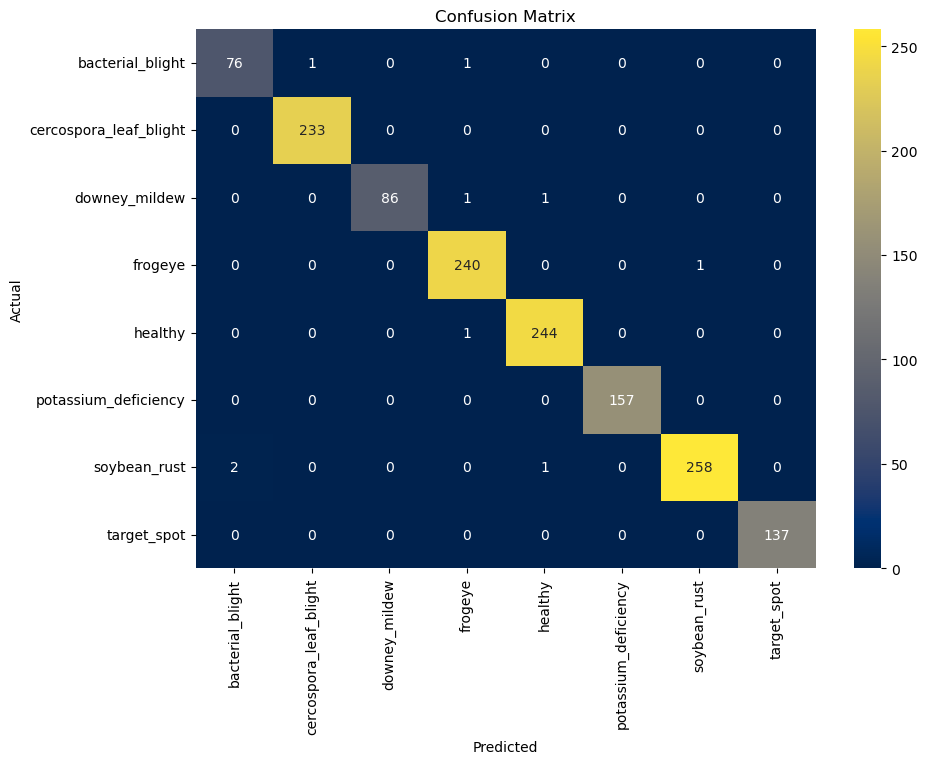

In [25]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cividis' , xticklabels = class_names, yticklabels =  class_names) # or use cmap = terrain
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

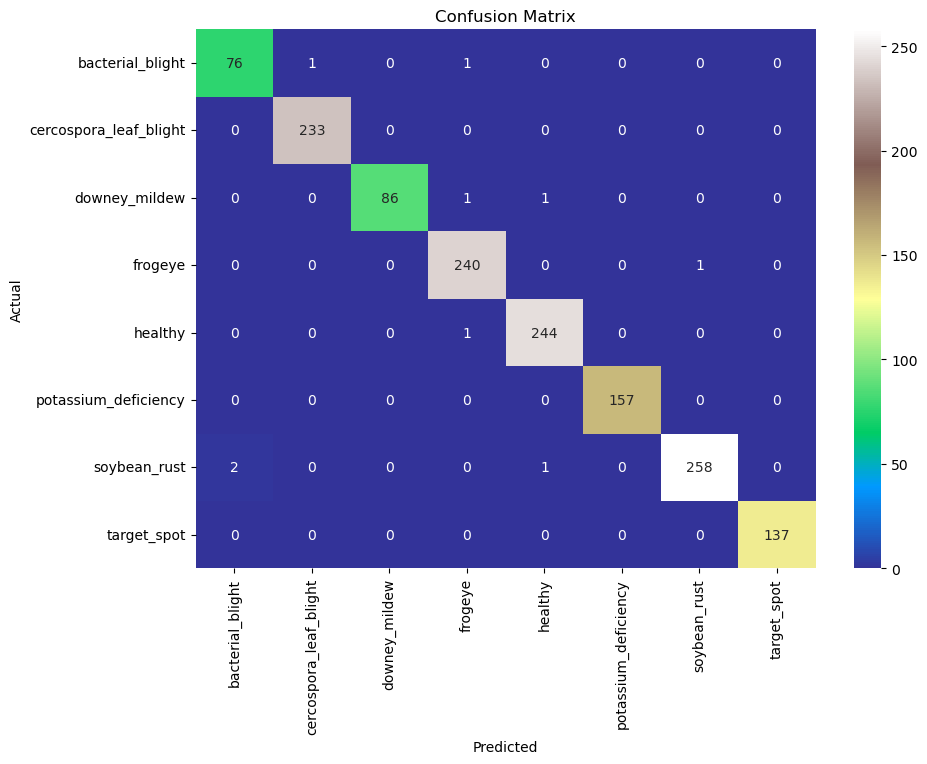

In [26]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='terrain' , xticklabels = class_names, yticklabels =  class_names) # or use cmap = terrain
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()